Last Friday, 21st August 2021, a few node operators reported some unusual occurences of an increased number of missed attestations and dropped participation rates in the Beacon Chain. 

On some investigation by various client teams and other stakeholders, the reason was this was found to be the slight increase in the orphaned blocks tracked down to a single Lido provider. 

An increase in orphaned blocks would imply an increase in attestations that need to be put in other blocks (which have a limit on the number of aggregates they can accomodate), leading to some attestations being dropped and validators being mildly affected for no fault of their own. 

[Ben Eddington](https://twitter.com/benjaminion_xyz) described the situation in great details in his [Twitter thread](https://twitter.com/benjaminion_xyz/status/1429044820383866896). Here is the description that he gives:

>I've just been writing up yesterday's little Eth2 beacon chain excitement for next week's What's New in Eth2.
>I thought I'd give you a quick tweet-thread preview.

>To be clear: the beacon chain was absolutely safe, no funds were at risk, no small animals were harmed.
>It's only noteworthy because, after almost 9 months of near-perfect running, any kind of incident is quite interesting.

>On Friday, my own validators missed two attestations. Missed attestations (votes that do not get on chain) happen, but are pretty rare. I noted it, but just assumed my ISP was acting up.

>A little later, @Allnodes a big Teku user, reported to us a significant increase in missed attestions: from the normal zero, to 15 in 12 hours. I checked some Discord forums: a handful of other stakers were reporting similar. It smelt like a network-wide issue.

>In addition, network participation (the proportion of total votes getting into blocks) was down by a percent or so. Not a big deal: 98% participation is totally fine, but still a hint that all was not perfect.
>I pinged the other devs, and the brains got to work Brain

>Nishant spotted that there were also unusual levels of orphaned blocks. These are blocks not included on chain, usually because they are produced too late. Also, the remaining blocks seemed to be unusually full of attestations (at capacity).

>The issue is that there is limited space in blocks for attestations. If blocks are orphaned/missing, that increases the number of attestations that must be put in other blocks, and blocks have hard cap of 128 aggregates. They were overflowing.

>The number of orphaned blocks was small, around one in a hundred or so, but the impact was noticeable. The reduced blockspace resulted in attestations being dropped and validators being (mildly) penalised through no fault of their own.

>Most of the orphaned blocks were tracked down to a single Lido provider. The Lighthouse team got in touch, they fixed whatever misconfiguration was going on, and everything returned to normal, near-perfect running.

>Again, this whole thing is a minor, almost trivial incident, and all is totally fine.
>However, it concerns me that an issue at an operator running only around 1% of validators had an impact noticeable across the network.

>It may be possible to decrease the impact of such outages by increasing the number of aggregate attestations included in blocks. It's currently 128, which is ok to keep the protocol safe, but results in innocent validators being penalised at times like this.

>But increasing this would make blocks larger, which is also not desireable. I'm sure we will discuss the trade-offs in due course. It's not a critical issue by any means, but more noticeable as the number of validators increases and blocks get fuller.

>The best remedy is not to use large staking pools, people!! The more diverse the network - clients, infrastructure, organisations - the less the impact of any single failure


It was also pointed out by PoS Ethereum Researcher [Danny Ryan](https://twitter.com/dannyryan) that another reason for this incident could be due to the fact that Prysm (The most widely used PoS Ethereum clients) does not refill mempool when blocks reorg'd. (The Prysm team was very quick to [resolve this](https://t.co/NzigRzj9xV?amp=1). 

What we observed, as Ben pointed out, could thus be beacuse of the clients that do refill the attestation pool not having enough space to include all the attestations that Prysm was dropping.

In this special edition of the Beacon Digest, we explore the impact of this incident on the Beacon Chain. We do so by analysing the following metrics which we know are directly impacted because of the incident:

- Attestation Count
- Orphaned Blocks (Number)
- Global Participation Rate 

In addition to this we also look into these metrics which mmight or might not have been indirectly affected by the incident:

- Validator Slashings
- Exit Counts


These minor incidences are worth dissecting to understand better how the beacon chain, a system driven by tens and thousands of stakeholders accross the globe, behaves with a change in the action of a single large entity. We'll also see how quickly the network is able to recover from these minor hiccups.

We observe these metrics from Epoch 58500 (Aug 18, 2021, 8:00 PM SGT) - Epoch 59560 (Aug 23, 2021, 1:04 PM SGT) to get a sense of how the network changed over time - before the incident, during the incident and after. 

Furthemore, we also dive into the attestation efficiency of 590 randomly selected Lido validators before and after the incident to see how these orphaned blocks affected the performance of the individual validators (in contrast to the impact on the overall network that we have been analyzing). 

## Housekeeping - data collection 

As usual, we begin with collecting all the data we need in order to carry out our analysis!

In [1]:
from web3 import Web3
import json
import requests
import csv
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from time import *
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.graph_objects as go
import math
import warnings

In [4]:
attestor_slashing = {}
proposer_slashing = {}
proposed_block_count = {}
global_participation_rate = {}
exit_counts = {}
deposits = {}
attestation_count = {}
orphaned_blocks = {}

In [5]:
# with open('api_key.txt', 'r') as api_file:
#     api_key = api_file.read()

for epoch in range(58500,59560):
    x = requests.get('https://beaconcha.in/api/v1/epoch/{}?api_key={}'.format(epoch, api_key))
    #Add a sleep to stay within the call rate limits
    sleep(6)
    
    data = x.json()['data']
    
    attestor_slashing[epoch] = data['attesterslashingscount']
    proposer_slashing[epoch] = data['proposerslashingscount']
    proposed_block_count[epoch] = data['proposedblocks']
    global_participation_rate[epoch] = data['globalparticipationrate']
    exit_counts[epoch] = data['voluntaryexitscount']
    deposits[epoch] = data['depositscount']
    attestation_count[epoch] = data['attestationscount']
    orphaned_blocks[epoch] = data['orphanedblocks']

In [6]:
#Writing the dictionaries to csv files

with open('attestor_slashing.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in attestor_slashing.items():
        wr.writerow([key,value])
        
with open('proposer_slashing.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in proposer_slashing.items():
        wr.writerow([key,value])
        
with open('proposed_block_count.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in proposed_block_count.items():
        wr.writerow([key,value])
        
with open('global_participation_rate.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in global_participation_rate.items():
        wr.writerow([key,value])
        
with open('exit_counts.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in exit_counts.items():
        wr.writerow([key,value])
        
with open('deposits.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in deposits.items():
        wr.writerow([key,value])
        
with open('attestation_count.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in attestation_count.items():
        wr.writerow([key,value])
        
with open('orphaned_blocks.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in orphaned_blocks.items():
        wr.writerow([key,value])

In [14]:
files = ["attestor_slashing", "proposer_slashing", "proposed_block_count", "global_participation_rate", "exit_counts", "deposits", "attestation_count", "orphaned_blocks"]
dfs = []

for file in files:
    df = pd.read_csv(f"{file}.csv", header=None, names=["epoch", file])
    df.dropna(subset=["epoch"], inplace=True)
    dfs += [df[[file]]] # We don't want the epoch column

df = pd.concat([df[["epoch"]]] + dfs, axis=1) # Concat everything, with the epoch column first
df["global_participation_rate"] *= 100 # Set to percentages
df = df[df.epoch < max(df["epoch"])] # Remove last epoch (queried too soon)
df["epoch"] = df["epoch"].astype(int)
df

,epoch,attestor_slashing,proposer_slashing,proposed_block_count,global_participation_rate,exit_counts,deposits,attestation_count,orphaned_blocks
0,58500,0,0,32,97.931033,0,0,3397,0
1,58501,0,0,32,96.418118,0,0,3272,0
2,58502,0,0,31,98.627383,0,0,3458,0
3,58503,0,0,32,99.394751,0,0,2817,0
4,58504,0,0,32,99.045461,0,0,2870,0
...,...,...,...,...,...,...,...,...,...
1054,59554,0,0,31,98.328453,0,54,3715,0
1055,59555,0,0,32,97.735530,0,0,3347,0
1056,59556,0,0,31,97.726738,0,0,3448,0
1057,59557,0,0,32,99.317855,0,0,2942,0


## Directly impacted metrics

### Attestation count

The first metric that we choose to analyze is - attestation counts. One of the major implications of an increased number of orphaned blocks was that other blocks were overflowing with attestations, because of which it becomes interesting to see how the attestation counts changed over time. 

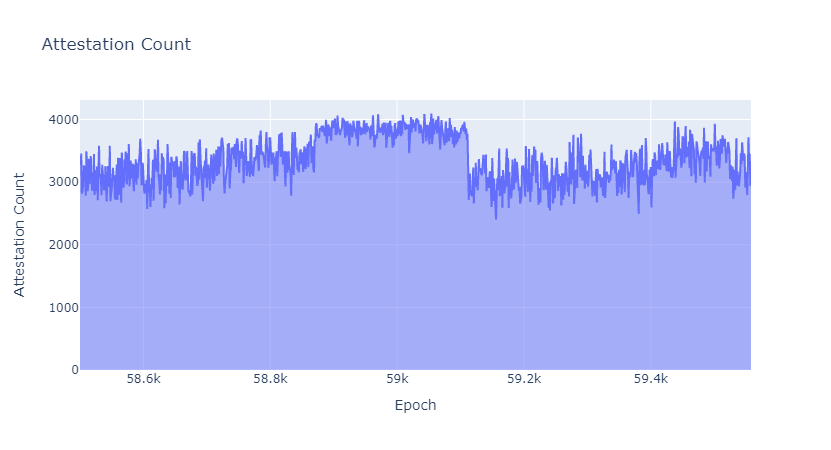

In [24]:
fig = px.area(df, x="epoch", y="attestation_count", title='Attestation Count', labels = {'epoch': 'Epoch', 'attestation_count': 'Attestation Count'})
fig.show()

We can see from the above graph that there was a sharp increase in the attestation counts from around epoch 58840 (Friday Aug 20, 2021, 8:16 AM SGT), after which it reaches its peak value. 

At its peak, the attestation count reached values as large as 4095. 

From about Epoch 59110 (Saturday Aug 21, 2021, 1:04 PM SGT) we see a huge drop in the attestation count after which we observe a somewhat fluctiating behaviour around a given range of values, consistent with the trend from before the increase. 

### Number of orphaned blocks

Given that the root cause of all the strange occurences which were observed was attributed to the increased number of orphaned blocks, this analysis would not be complete without looking specifically into just how many blocks were orphaned.

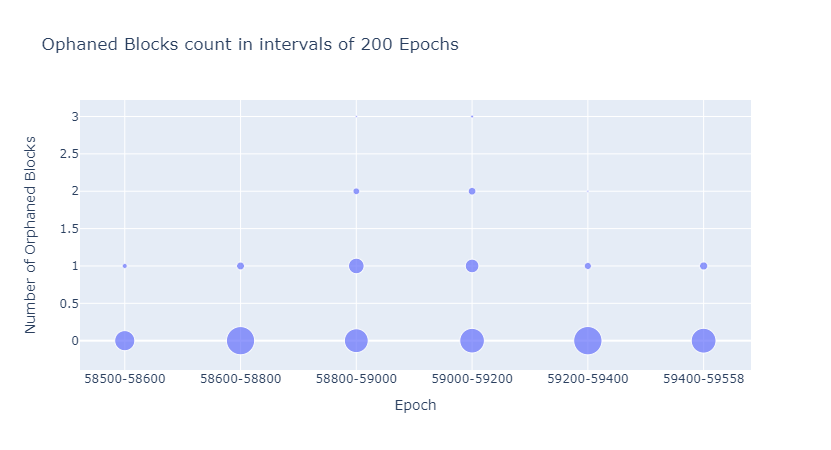

In [29]:
bucket_size = 200
df["bucket"] = np.floor_divide(df["epoch"], bucket_size)
df["n_bxs"] = 1
df_bucket = df[["bucket", "orphaned_blocks", "n_bxs"]].groupby(["bucket", "orphaned_blocks"]).sum("n_bxs").reset_index()
df_bucket["epoch"] = df_bucket.bucket.apply(
    lambda bucket: f"{max(min(df['epoch']), bucket * bucket_size)}-{min(max(df['epoch']), (bucket + 1) * bucket_size)}"
)

fig = px.scatter(df_bucket, x = 'epoch', y = 'orphaned_blocks', size = 'n_bxs',
                 labels={ "orphaned_blocks": "Number of Orphaned Blocks", "epoch": "Epoch", "n_bxs": "Count" },
                 title = f"Ophaned Blocks count in intervals of {bucket_size} Epochs")
fig

When we plot the orphaned block counts in intervals of 200 epochs, we can clearly deduce that out of all the epoch intervals in consideration, the intervals (58800 - 59000) and (59000 - 59200):

- Have considerably lesser epochs with 0 orphaned blocks 
    - 132 and 141 vs what was otherwise around 185
- Have considerably higher epochs with 1 orphaned block 
    - 56 and 43 vs what was otherwise around 12-16
- Were the only intervals to have epochs with 2 orphaned blocks 
    - Counts were: 11 and 14

### Global participation rate

We continue our analysis by looking at how the participation rate was affected by this mini incident.

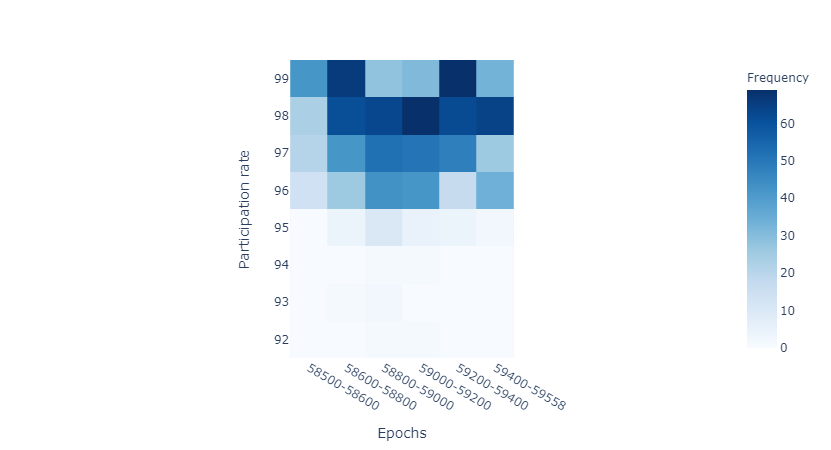

In [31]:
bins = pd.IntervalIndex.from_tuples([(i,i+1) for i in range(int(min(df["global_participation_rate"])), 100)][::-1])
df["participation_bin"] = pd.cut(df["global_participation_rate"], bins)
df_bucket = df[["bucket", "participation_bin", "n_bxs"]].groupby(["bucket", "participation_bin"]).sum("n_bxs").reset_index()
epoch_names = df_bucket.bucket.apply(
    lambda bucket: f"{max(min(df['epoch']), bucket * bucket_size)}-{min(max(df['epoch']), (bucket + 1) * bucket_size)}"
)
df_bucket["epoch"] = epoch_names
df_bucket = df_bucket[["participation_bin", "n_bxs", "epoch"]].pivot(index="participation_bin", columns=["epoch"])

px.imshow(
    df_bucket.to_numpy(),
    labels=dict(x="Epochs", y="Participation rate", color="Frequency"),
    x = sorted(list(set(epoch_names))),
    y = [str(s) for s in np.flip(np.arange(int(min(df["global_participation_rate"])), 100))],
    color_continuous_scale='blues'
)

We see that the epoch intervals (58800 - 59000) and (59000 - 59200) continue to show anomalous behaviour* when compared to other intervals. Specifically in these ranges:

- The participation of most epochs lie between 97% - 98% (compared to 98% - 99% which we see for most other epochs)
- The number of epochs for which the participation rate were between of 96% - 97% is also considerably higher 

In fact specifically for the range (58800 - 59000) we see epochs for which the participation rate fell to values as low as 92.2 which is in general quite rare.

<sup>* Anomalous here refers to the fact that the participation rate is not only lower when compared to the other epochs in consideration but also to all other epochs that we have analysed ever since the inception of the Beacon Digest</sup>

## Other metrics

### Validator slashing incidents

While there are no direct reports of this metric being affected by the overflowing attestations, we thought it would still be interesting to look into these to show how despite small occurances such as this, most parts of this complex system called the Beacon Chain still continue to function as per usual. 

#### Attester slashing

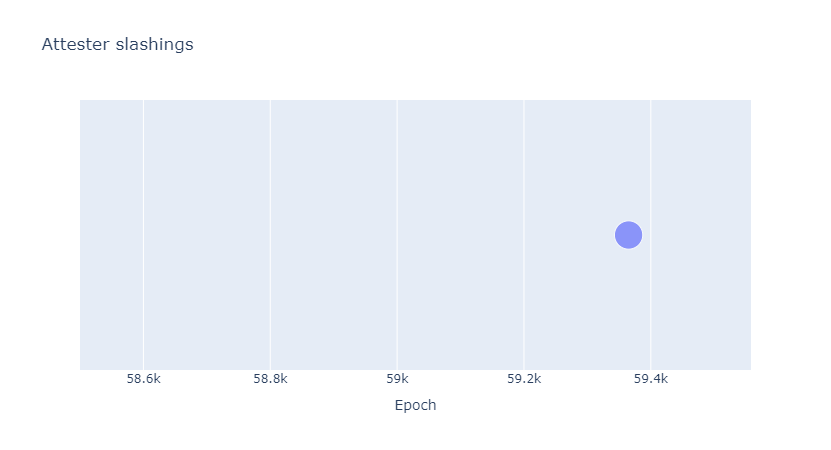

In [33]:
rng = np.random.default_rng(42)
df['temp'] = rng.uniform(0, 10, len(df["epoch"]))
fig = px.scatter(
    df[df.attestor_slashing > 0], x = 'epoch', y = 'temp', size = 'attestor_slashing',
    size_max = 20, labels = {"epoch": "Epoch"},
    title = f"Attester slashings"
)
fig.update_xaxes(range=(min(df["epoch"]), max(df["epoch"])))
fig.update_yaxes(visible=False)

#### Proposer slashing

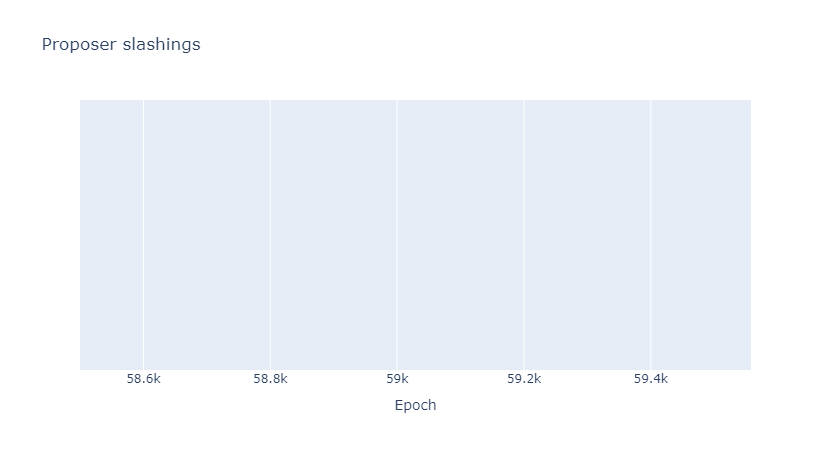

In [34]:
fig = px.scatter(
    df[df.proposer_slashing > 0], x = 'epoch', y = 'temp', size = 'proposer_slashing',
    size_max = 20, labels = {"epoch": "Epoch"},
    title = f"Proposer slashings"
)
fig.update_xaxes(range=(min(df["epoch"]), max(df["epoch"])))
fig.update_yaxes(visible=False)

We note that there was 1 attester slashing event and 0 proposer slashing events for this range of epochs, both of which are not any really unusual in any way 

### Exit counts

We also thought that it would be interesting to see if many validators or rather if any validator tried to initiaite a voluntarily exit given that there were a few validators who were, as Ben put it, being (mildly) penalised through no fault of their own.

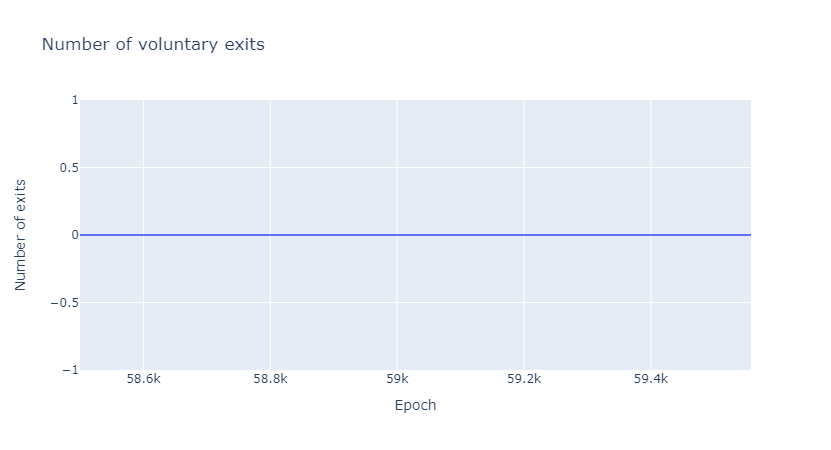

In [36]:
px.line(x=df['epoch'], y=df['exit_counts'], labels = {"x": "Epoch", "y": "Number of exits"}, title = "Number of voluntary exits")

We observe that there were 0 voluntary exits for this range of epochs

## Lido performance

While so far our focus has been on mainly looking at how this incident has impacted the network as a whole, we now switch gears and look at how is has affected the long-term performance of 590 randomly selected Lido validators (Since the source of the incident was traced to a Lido operator) 

### Attestation efficiency 

The first metric that we look at is Attestation Effectiveness. While more orphaned blocks do not necessarily mean a decrease in the validator's efficiency, it will still be interesting to analyze whether Lido attestations were also not to the mark (as they were before) the mark during this period.  

As explained in great detail in this [blog post by Attestant](https://www.attestant.io/posts/defining-attestation-effectiveness/), this metric gives us an idea of the usefulness of an attestation in terms of both block production and inclusion distance. 

The formula to calculate the attestation efficiency of a single attestation is:

$$ \frac{earliest\ inclusion\ slot-attestation\ slot}{actual\ inclusion\ slot-attestation\ slot} $$

When we average this out for multiple attestations, we get a metric that is an indication of how "effective" the validator has been in performing their duties 

We look at the average attestation efficiency of 590 randomly selected Lido validators:

1) Based off the data we scrpaed on 8th August 2021
2) Based off the data we scraped today (on 23rd August 2021)

to see how it changed over the course of this incident.

In [41]:
names = ['Validator Index', 'Attestation Efficiency']
df1 = pd.read_csv('lido_effectiveness_0809.csv', header = None, names = names)

In [53]:
names = ['Validator Index', 'Attestation Efficiency']
df2 = pd.read_csv('lido_effectiveness_0823.csv', header = None, names = names)

In [ ]:
nan_value = float("NaN")
df2.replace("", nan_value, inplace=True)
df2.dropna(subset = ["Validator Index"], inplace=True)
df2.reset_index()

In [58]:
print("Summary stats of efficiency before the incident")
df1['Attestation Efficiency'].describe()

Summary stats of efficiency before the incident


count    591.000000
mean       0.993807
std        0.013123
min        0.916667
25%        0.990099
50%        1.000000
75%        1.000000
max        1.000000
Name: Attestation Efficiency, dtype: float64

In [59]:
print("Summary stats of efficiency after the incident")
df2['Attestation Efficiency'].describe()

Summary stats of efficiency after the incident


count    591.000000
mean       0.992666
std        0.017333
min        0.847458
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Attestation Efficiency, dtype: float64

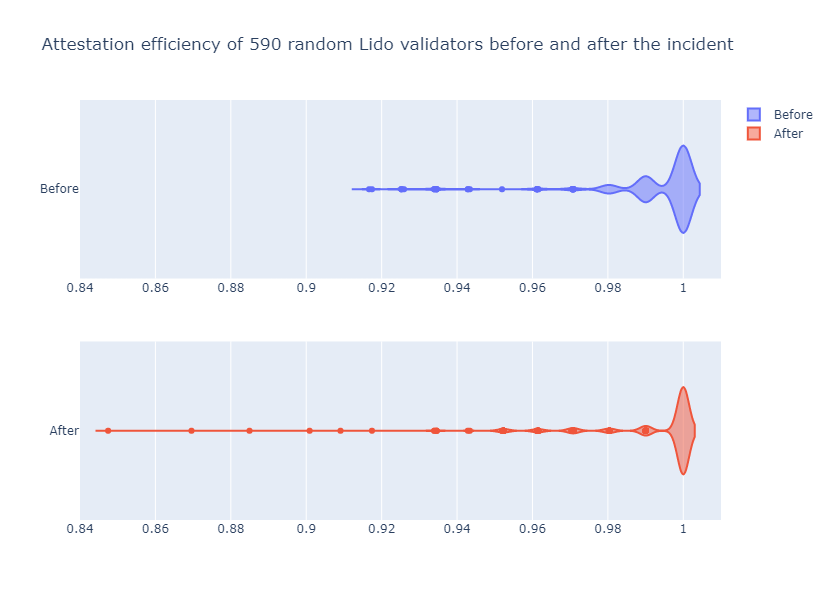

In [67]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Violin(
    name = 'Before',
    x= df1['Attestation Efficiency']
), row=1, col=1)

fig.append_trace(go.Violin(
    name = 'After',
    x=df2['Attestation Efficiency'],
), row=2, col=1)

fig.update_layout(height=600, width=600, title_text="Attestation efficiency of 590 random Lido validators before and after the incident")
fig.update_xaxes(range=[0.84, 1])
fig.update_xaxes(range=[0.84, 1.01])
fig.show()

While the attestation efficiency of most validators continue to be between 0.95 - 1 even after the incident, the value for some validators went below 0.9 which was previously not the case. 

We also see from the summary stastics that the mean also fell down from 0.993807 to 0.992666. 

Overall the attestation efficiencies of most validators still remain quite high while those of a few have fallen to relatively lesser values.

### Validator earnings

To conclude our analysis, we look into the day-wise earnings of Lido validator #96325, which on 08/09 had an attestation efficiency of 1 and on 08/23 an attestation efficiency of about 0.87.

We know that validator earnings are directly and negatively impacted by orphaned blocks, but we do not expect a large enough deviation to sound off an "anomaly detector", due to the high variability in rewards given the stochastic nature of block production.

(If a validator is by chance called on to produce a block on day n, their earnings for that day will be a lot higher than on days when they were not called on to propose a block. But being called on to produce a block is probablistic in nature)

In [68]:
x = requests.get('https://beaconcha.in/api/v1/validator/stats/96325?api_key={}'.format(api_key))
data = x.json()['data']
earnings_dict = {}

for i in data:
    earnings_dict[i['day'] - 261] = i['end_balance'] - i['start_balance']  

In [73]:
df_earnings = pd.DataFrame(list(earnings_dict.items()),columns = ['Days since incident','Earnings'])

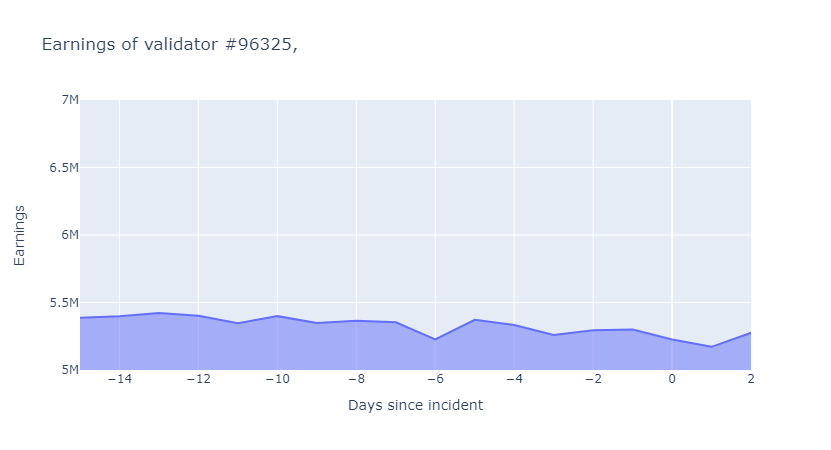

In [81]:
fig = px.area(df_earnings, x="Days since incident", y="Earnings", title='Earnings of validator #96325,')
fig.update_xaxes(range=[-15, 2])
fig.update_yaxes(range=[5000000, 7000000])
fig.show()

If we look at the earnings of the validator over a period of 15-days, we see that while there is a small dip in their earnings 1 day after the incident, as we hypothised the dip is not significant enough to sound off any alarm that something out of the blue has happened. 

This means that despite this small incident, people who have staked their ETH using Lido will still continue to get good returns on their investment. 

## Conclusion